In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar import vecm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
#from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *

In [120]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')
#display(data)

spy_data = data[['Date', 'GDP', 'PCEPI', 'M2SL', 'SPX Total', '10Y Treasury', 'Futures Shock', 'Unemployment', 'FEDFUNDS']].dropna()
spy_data.set_index('Date', inplace=True)
display(spy_data)

,GDP,PCEPI,M2SL,SPX Total,10Y Treasury,Futures Shock,Unemployment,FEDFUNDS
Date,,,,,,,,
1992-01-01,6315.72500,62.638,3381.2,408.8,7.03,0.000000,7.3,4.03
1992-02-01,6356.50400,62.797,3400.0,412.7,7.34,0.004572,7.4,4.06
1992-03-01,6417.07700,62.949,3403.9,403.7,7.54,0.000000,7.4,3.98
1992-04-01,6443.25700,63.119,3399.7,414.9,7.48,-0.258935,7.4,3.73
1992-05-01,6433.81000,63.203,3398.6,415.4,7.39,0.012382,7.6,3.82
...,...,...,...,...,...,...,...,...
2023-09-01,27824.67800,121.267,20710.1,4288.1,4.38,0.051324,3.8,5.33
2023-10-01,27732.56464,121.309,20698.7,4193.8,4.80,0.000000,3.8,5.33
2023-11-01,27948.82775,121.296,20724.9,4567.8,4.50,-0.013891,3.7,5.33


In [121]:
# ADF TEST
# List of column names to check for stationarity
columns_to_check = ['GDP', 'PCEPI', 'M2SL', 'SPX Total', '10Y Treasury', 'Futures Shock', 'Unemployment', 'FEDFUNDS']

# Function to run ADF test and print results
def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Test for {column_name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    print('\n')

# Apply the ADF test to each column
for col in columns_to_check:
    adf_test(spy_data[col], col)

ADF Test for GDP:
ADF Statistic: 3.3539876538147704
p-value: 1.0
Critical Values:
    1%: -3.4476763783532585
    5%: -2.869176103659426
    10%: -2.570837873961219


ADF Test for PCEPI:
ADF Statistic: 1.452712651247475
p-value: 0.9973409312180768
Critical Values:
    1%: -3.448196541708585
    5%: -2.869404683789669
    10%: -2.5709597356805545


ADF Test for M2SL:
ADF Statistic: 1.0743425056547367
p-value: 0.9949915866205322
Critical Values:
    1%: -3.4477224095888497
    5%: -2.869196333125208
    10%: -2.5708486586002604


ADF Test for SPX Total:
ADF Statistic: 1.9754822320170715
p-value: 0.998640233364133
Critical Values:
    1%: -3.448147967010838
    5%: -2.8693833397824413
    10%: -2.5709483564645725


ADF Test for 10Y Treasury:
ADF Statistic: -2.211981802370867
p-value: 0.2019255302517079
Critical Values:
    1%: -3.4476305904172904
    5%: -2.869155980820355
    10%: -2.570827146203181


ADF Test for Futures Shock:
ADF Statistic: -10.36092413300067
p-value: 2.39773561576431

In [122]:
# List of columns to check for stationarity
#columns_to_check = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
columns_to_check = ['Futures Shock', 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total']

# Function to conduct ADF tests and identify non-stationary variables
def check_stationarity(data):
    non_stationary_cols = []
    for col in columns_to_check:
        result = adfuller(data[col].dropna())
        if result[1] > 0.05:  # p-value greater than 0.05 indicates non-stationarity
            non_stationary_cols.append(col)
        print(f"{col}: ADF Statistic = {result[0]}, p-value = {result[1]}")
    return non_stationary_cols

non_stationary_cols = check_stationarity(spy_data)
print(f"Non-stationary columns: {non_stationary_cols}")

Futures Shock: ADF Statistic = -10.36092413300067, p-value = 2.3977356157643105e-18
M2SL: ADF Statistic = 1.0743425056547367, p-value = 0.9949915866205322
PCEPI: ADF Statistic = 1.452712651247475, p-value = 0.9973409312180768
10Y Treasury: ADF Statistic = -2.211981802370867, p-value = 0.2019255302517079
GDP: ADF Statistic = 3.3539876538147704, p-value = 1.0
Unemployment: ADF Statistic = -3.1889544884366394, p-value = 0.020633005485187286
SPX Total: ADF Statistic = 1.9754822320170715, p-value = 0.998640233364133
Non-stationary columns: ['M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'SPX Total']


In [123]:
spy_data_diff = spy_data.copy()

# Apply differencing
for col in ['GDP', 'PCEPI', 'M2SL', 'SPX Total']:
    spy_data_diff[col] = np.log(spy_data[col]).diff()

#for col in ['FEDFUNDS']:
for col in ['10Y Treasury']:
    spy_data_diff[col] = spy_data[col].diff()

spy_data_diff.dropna(inplace=True)

In [124]:
# Reorder the columns so that 'Futures Shock' is first
#ordered_columns = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
ordered_columns = ['Futures Shock', 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total']
spy_data_ordered = spy_data_diff[ordered_columns]
print(spy_data_ordered)

            Futures Shock      M2SL     PCEPI  10Y Treasury       GDP  \
Date                                                                    
1992-02-01       0.004572  0.005545  0.002535          0.31  0.006436   
1992-03-01       0.000000  0.001146  0.002418          0.20  0.009484   
1992-04-01      -0.258935 -0.001235  0.002697         -0.06  0.004071   
1992-05-01       0.012382 -0.000324  0.001330         -0.09 -0.001467   
1992-06-01       0.000000 -0.001531  0.001770         -0.13  0.015639   
...                   ...       ...       ...           ...       ...   
2023-09-01       0.051324 -0.002570  0.003834          0.21  0.007331   
2023-10-01       0.000000 -0.000551  0.000346          0.42 -0.003316   
2023-11-01      -0.013891  0.001265 -0.000107         -0.30  0.007768   
2023-12-01      -0.051664  0.002949  0.001252         -0.48  0.008565   
2024-01-01       0.021353  0.000197  0.003764          0.04 -0.002911   

            Unemployment  SPX Total  
Date        

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, May, 2024
Time:                     02:39:38
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -48.9220
Nobs:                     380.000    HQIC:                  -50.1916
Log likelihood:           6123.73    FPE:                6.92181e-23
AIC:                     -51.0269    Det(Omega_mle):     4.13659e-23
--------------------------------------------------------------------
Results for equation Futures Shock
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.022682         0.011966           -1.896           0.058
L1.Futures Shock        -0.005705         0.053985           -0.106           0.916
L1.M2SL                  0.266140       

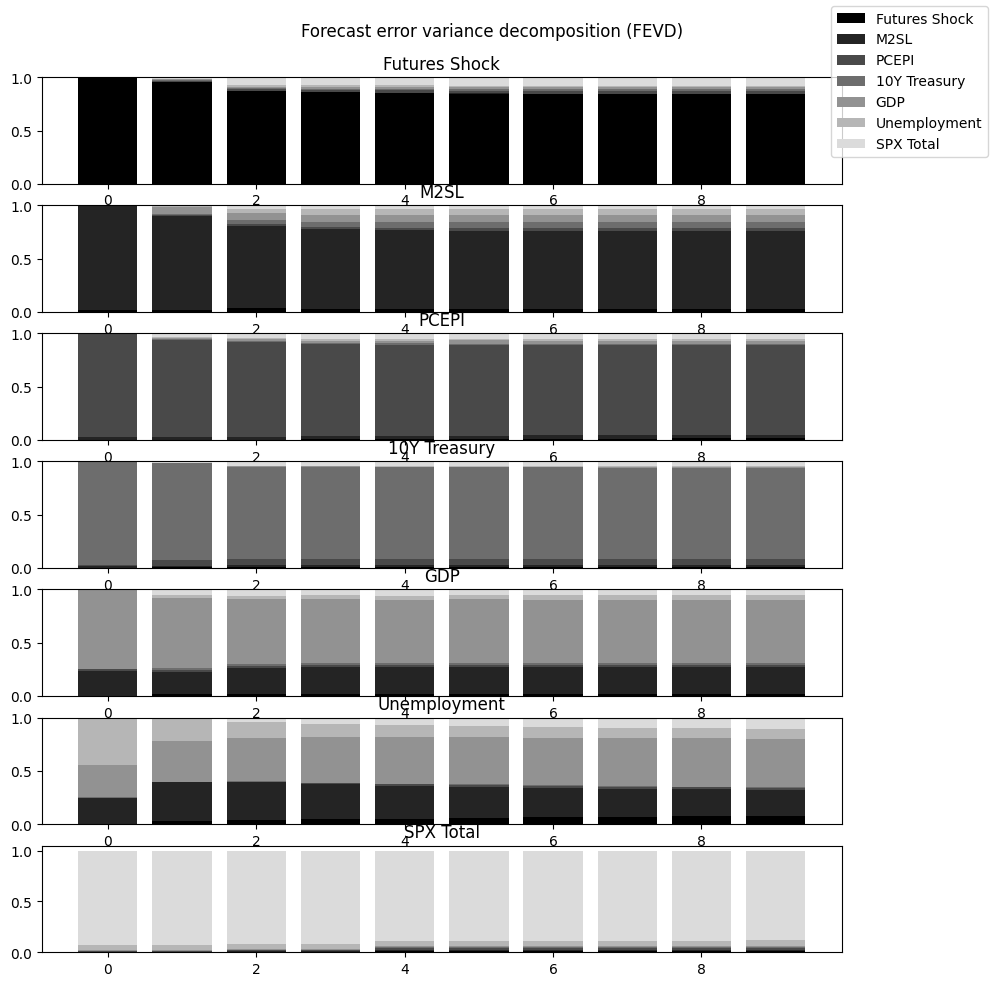

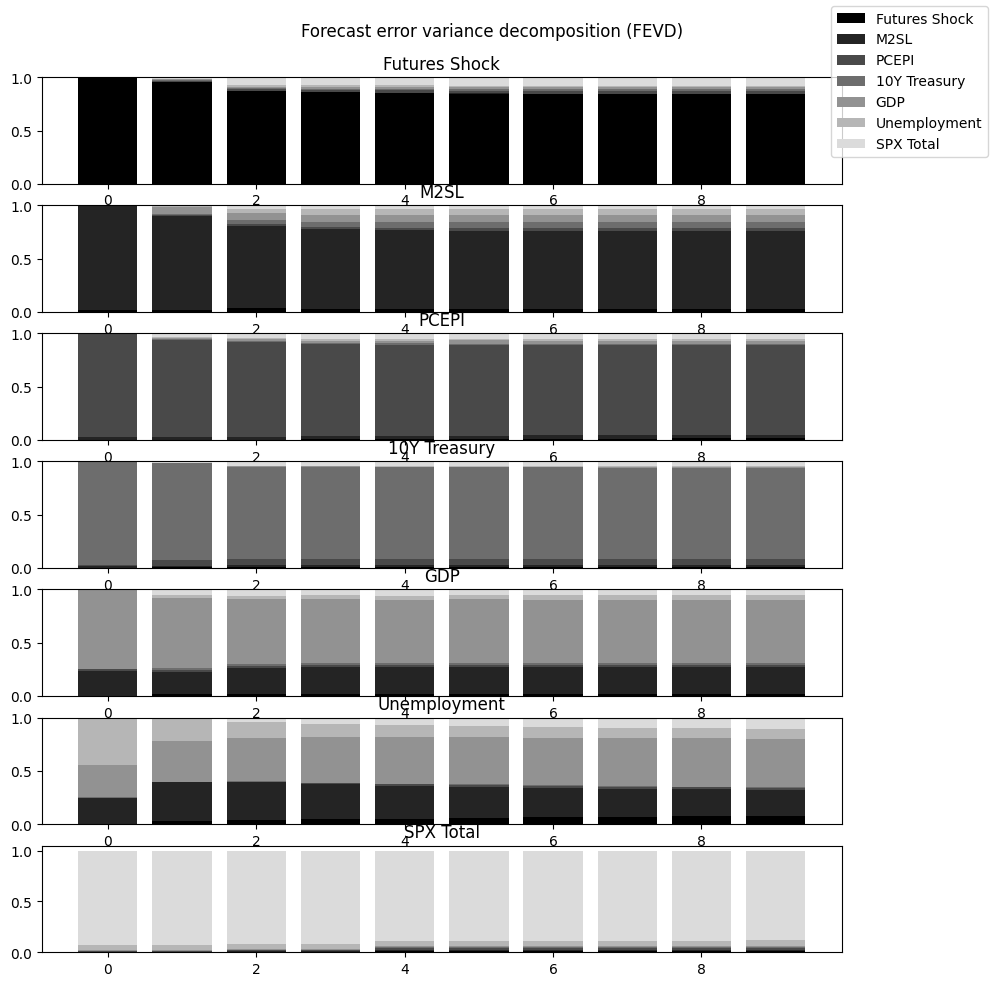

In [186]:
# Initialize and fit the VAR model
model_var = VAR(spy_data_ordered)
lag_selection = model_var.select_order(maxlags=12)
optimal_lags = lag_selection.aic

# Fit the VAR model with the chosen lag length
var_results = model_var.fit(optimal_lags)
print(var_results.summary())
#fevd = var_results.fevd() works for VAR but not SVAR
#fevd.plot(10)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


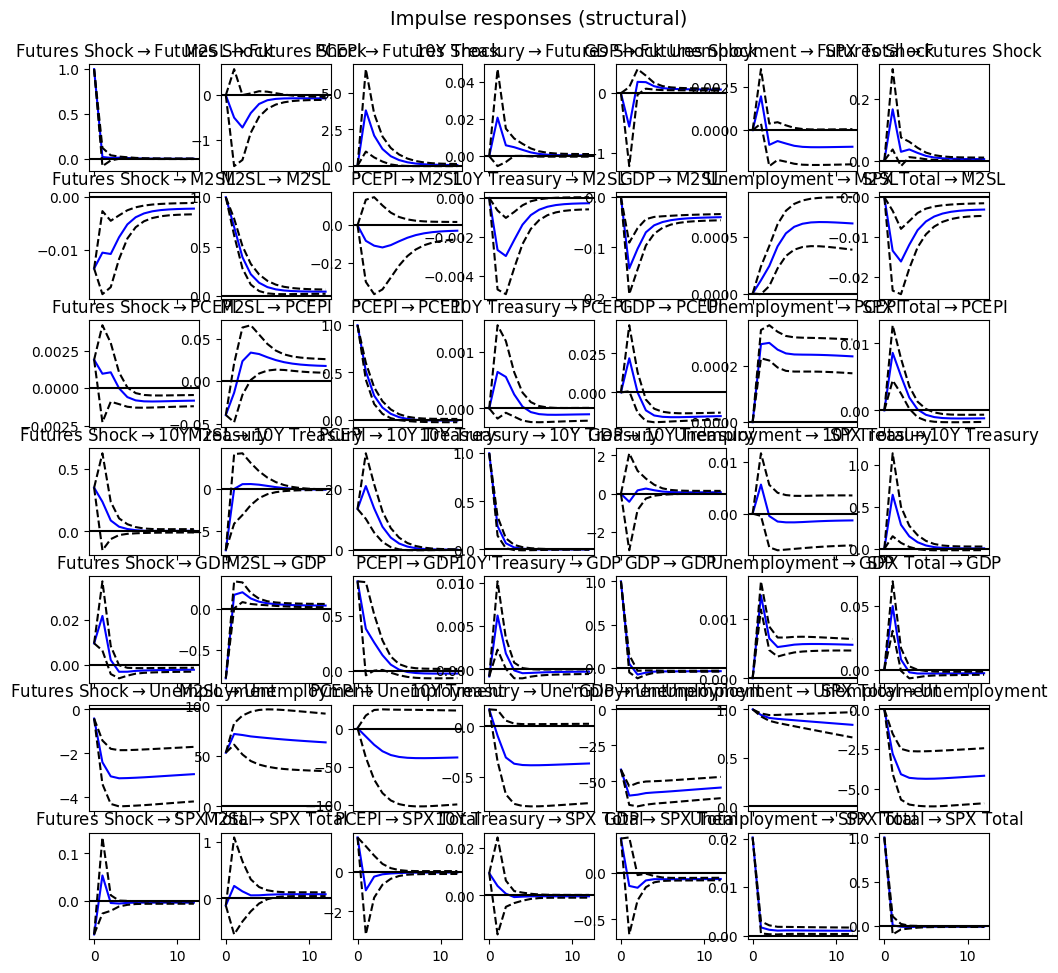

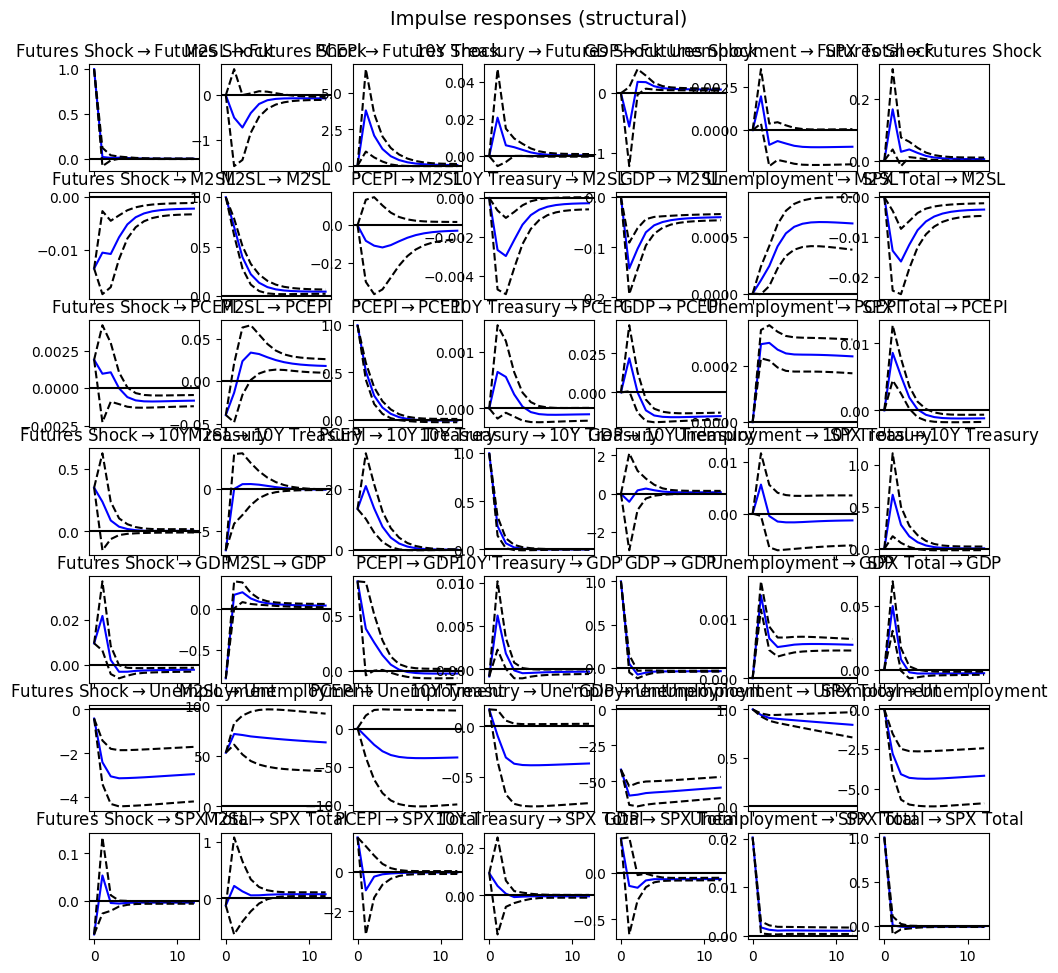

In [179]:
import numpy as np
from statsmodels.tsa.vector_ar.svar_model import SVAR, SVARResults

# Identification matrix to enforce the zero-lag impact on m_t
A = np.array([
    [1, 0, 0, 0, 0, 0, 0],  # Futures Shock (exogenous)
    ['E', 1, 0, 0, 0, 0, 0],  # M2SL influenced by Futures Shock
    ['E', 'E', 1, 0, 0, 0, 0],  # PCEPI depends on Futures Shock and M2SL
    ['E', 'E', 'E', 1, 0, 0, 0],  # FEDFUNDS depends on prior variables or 10Y Treasury too
    ['E', 'E', 'E', 'E', 1, 0, 0],  # GDP depends on prior variables
    ['E', 'E', 'E', 'E', 'E', 1, 0],  # Unemployment depends on prior variables
    ['E', 'E', 'E', 'E', 'E', 'E', 1]   # SPX Total depends on all prior variables
])

# Model misspecification ? Not sure on the correct order

# Fit the SVAR model with the identification matrix
model_svar = SVAR(spy_data_ordered, svar_type='A', A=A)
svar_results = model_svar.fit(trend='n') # not sure if 'c' or 'ctt'

# Generate and plot IRFs
svar_irf = svar_results.irf(periods=12)
svar_irf.plot()


In [166]:
roots = svar_results.roots

all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


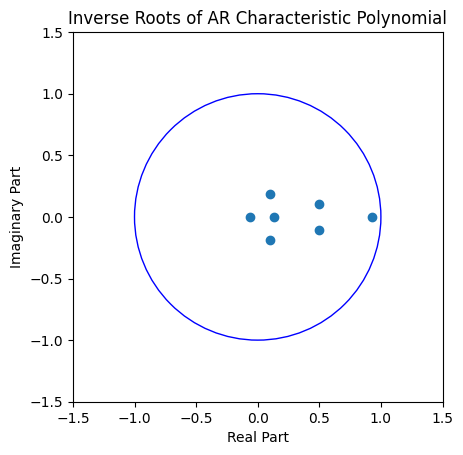

In [167]:
# Calculate inverse roots
inverse_roots = 1 / roots

# Create a new figure
plt.figure()

# Plot the real part on the x-axis and the imaginary part on the y-axis
plt.scatter(inverse_roots.real, inverse_roots.imag)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Set the x and y limits to be the same
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Inverse Roots of AR Characteristic Polynomial')

# Show the plot
plt.show()

In [145]:
# Assuming `svar_results` is the fitted results object
# Retrieve residuals and variable names from the fitted SVAR results
residuals = svar_results.resid
variable_names = svar_results.names

# Example of the Jarque-Bera test for normality
from scipy.stats import jarque_bera

for i, var in enumerate(variable_names):
    jb_test = jarque_bera(residuals[:, i])
    print(f"Normality Test for {var}: Statistic={jb_test[0]}, p-value={jb_test[1]}")

# we need to correct outliers, variables deviate from normality

Normality Test for Futures Shock: Statistic=5978.232744954029, p-value=0.0
Normality Test for M2SL: Statistic=3436.5034016271516, p-value=0.0
Normality Test for PCEPI: Statistic=125.60516351845801, p-value=5.311109955642251e-28
Normality Test for 10Y Treasury: Statistic=7.151496398321718, p-value=0.027994472495756595
Normality Test for GDP: Statistic=35683.31143524498, p-value=0.0
Normality Test for Unemployment: Statistic=519040.2889926937, p-value=0.0
Normality Test for SPX Total: Statistic=77.15384895106035, p-value=1.7630091710667548e-17


In [160]:
print(svar_results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 41710.587, critical value: 23.685>, p-value: 0.000>


In [156]:
print(svar_results.test_whiteness())

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 664.319, critical value: 490.960>, p-value: 0.000>


In [170]:
#granger causality

AttributeError: 'SVARResults' object has no attribute 'lag_order'

In [151]:
import statsmodels.stats.diagnostic as smd
import pandas as pd

# Access the residuals and predictor variables from the fitted SVAR model
residuals = pd.DataFrame(svar_results.resid, columns=svar_results.names)

# Retrieve endogenous variables used as predictors
predictors = pd.DataFrame(svar_results.endog, columns=svar_results.names)

# Conduct the White test for each residual series
for i, col in enumerate(residuals.columns):
    white_test = smd.het_white(residuals[col], predictors)
    print(f"White Test for {col}: LM Statistic={white_test[0]}, p-value={white_test[1]}")


ValueError: resid is required to have shape (384, 1) but has shape (383, 1)

In [152]:
# Example of performing the Breusch-Godfrey test for autocorrelation
import statsmodels.stats.diagnostic as smd

# Perform the Breusch-Godfrey test
lm_test = smd.acorr_breusch_godfrey(svar_results, nlags=10)

# Print the results of the test
print(f"Breusch-Godfrey Test: LM Statistic={lm_test[0]}, p-value={lm_test[1]}")


ValueError: Model resid must be a 1d array. Cannot be used on multivariate models.

<Axes: title={'center': 'Local Projection for SPX Total'}, xlabel='Horizon (Periods Ahead)', ylabel='Response'>

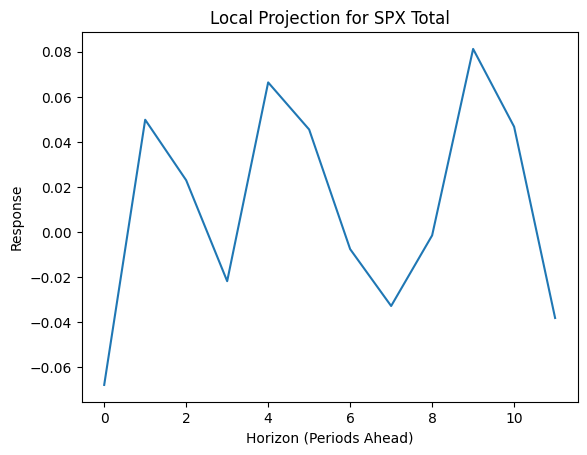

In [92]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Set the shock variable (assumed exogenous)
shock_variable = 'Futures Shock'

horizons = range(0, 12)

# Initialize a dictionary to store results for each response variable
responses = {var: [] for var in spy_data_ordered.columns if var != shock_variable}

# Fit a local projection model for each horizon and response variable
for h in horizons:
    for response_var in responses:
        # Shift the response variable by the horizon value
        target = spy_data_ordered[response_var].shift(-h).dropna()

        # Ensure predictors are aligned with the shifted target
        predictors = spy_data_ordered[[shock_variable]].loc[target.index]

        # Add a constant term to predictors
        predictors = sm.add_constant(predictors)

        # Fit an Ordinary Least Squares (OLS) regression
        model = sm.OLS(target, predictors).fit()

        # Append the coefficient for the shock variable
        responses[response_var].append(model.params[shock_variable])

# Convert responses to a DataFrame for easier analysis
response_df = pd.DataFrame(responses, index=horizons)

response_df['SPX Total'].plot(title="Local Projection for SPX Total", xlabel="Horizon (Periods Ahead)", ylabel="Response")